In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import cv2 as cv
import os
import DarkArtefactRemoval as dca
import dullrazor as dr
import segmentation_and_preprocessing as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import gradcam_test as gc
import vanilla_backprop as vb
import seaborn as sns

# Loading Data

In [23]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'
image_dir_test = 'Test/Test/'

Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

#Lire le csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')
metadataTest = pd.read_csv('metadataTest.csv')



In [24]:

lesions_segmentes = glob.glob('output_masks_train_set_1/*.png')
lesions_segmentes_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in lesions_segmentes]

binary_masks = glob.glob('output_binary_masks_train_set_1/*.png')
binary_masks_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in binary_masks]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(lesions_segmentes_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(lesions_segmentes_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()



In [25]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')
print('There are', len(lesions_segmentes),  'segmented lesions')
print('There are', len(binary_masks),  'binary masks')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks
There are 18998 segmented lesions
There are 18998 binary masks


In [26]:
# Réordonner les images
lesions_segmentes_ordered = []
binary_masks_ordered = []
lesions_segmentes_ordered_names = []
binary_masks_ordered_names = []
images_train_ordered = []
for i in range(0, len(names_list)):
    for j in range(0, len(lesions_segmentes_names)):
        if names_list[i] in lesions_segmentes_names[j]:
            lesions_segmentes_ordered.append(lesions_segmentes[j])
            binary_masks_ordered.append(binary_masks[j])
            images_train_ordered.append(images_train[i])
            lesions_segmentes_ordered_names.append(lesions_segmentes_names[j])
            binary_masks_ordered_names.append(binary_masks_names[j])

### Compute the segmentation mask for all the 20 000 images of the training set

# CNN

### Préparation des données

- Images carrées de 256x256
- Normalisation des images
- Augmentation des données

### Prepare data for CNN

##### Train test split

In [27]:
X_train = lesions_segmentes_ordered
X_train = np.array(X_train)
y_train = classes_list
y_train = np.array(y_train)

#----------------------------------
#y_train = y_train - 1
#----------------------------------
print(len(X_train))
print(len(y_train))

print(X_train)
print(y_train)
#Créer la validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

#créer le csv avec la correspondance nom - class
with open('X_train_ID_class.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'CLASS'])
    for i in range(len(X_train)):
        writer.writerow([X_train[i], y_train[i]])

with open('X_val_ID_class.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'CLASS'])
    for i in range(len(X_val)):
        writer.writerow([X_val[i], y_val[i]])



df_train = pd.read_csv('X_train_ID_class.csv')
df_val = pd.read_csv('X_val_ID_class.csv')
df_train['CLASS'] = df_train['CLASS'].astype(str)
df_val['CLASS'] = df_val['CLASS'].astype(str)



for i in range(len(df_train)):
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('1', 'CLASS1')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('2', 'CLASS2')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('3', 'CLASS3')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('4', 'CLASS4')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('5', 'CLASS5')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('6', 'CLASS6')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('7', 'CLASS7')
    df_train['CLASS'][i] = df_train['CLASS'][i].replace('8', 'CLASS8')
print(df_train)



18998
18998
['output_masks_train_set_1/ISIC_0028766.jpg_pred_mask.png'
 'output_masks_train_set_1/ISIC_0071222.jpg_pred_mask.png'
 'output_masks_train_set_1/ISIC_0069434.jpg_pred_mask.png' ...
 'output_masks_train_set_1/ISIC_0030034.jpg_pred_mask.png'
 'output_masks_train_set_1/ISIC_0027095.jpg_pred_mask.png'
 'output_masks_train_set_1/ISIC_0031967.jpg_pred_mask.png']
[2 8 3 ... 1 2 5]
                                                      ID   CLASS
0      output_masks_train_set_1/ISIC_0012711.jpg_pred...  CLASS2
1      output_masks_train_set_1/ISIC_0067801.jpg_pred...  CLASS2
2      output_masks_train_set_1/ISIC_0026869.jpg_pred...  CLASS2
3      output_masks_train_set_1/ISIC_0069630.jpg_pred...  CLASS4
4      output_masks_train_set_1/ISIC_0032969.jpg_pred...  CLASS2
...                                                  ...     ...
15193  output_masks_train_set_1/ISIC_0028785.jpg_pred...  CLASS2
15194  output_masks_train_set_1/ISIC_0063294.jpg_pred...  CLASS2
15195  output_masks_train_

(array([2758., 7707., 1975.,    0.,  529., 1583.,    0.,  140.,  140.,
         366.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

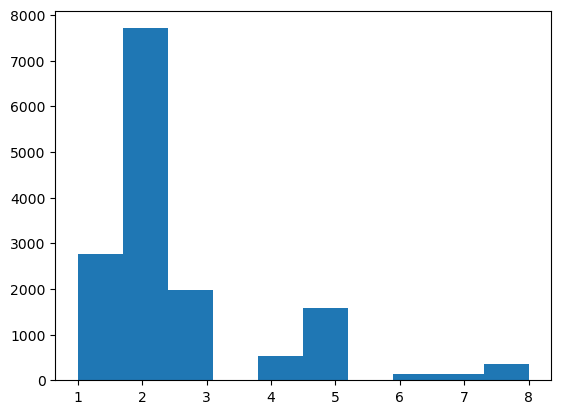

In [28]:
plt.hist(y_train)

# ATTENTION Y_train entre 1 et 8

# Modification j'ajoute -1 pour le passer entre 0 et 7 pour le CNN

# Ne pas oubliez de faire la démarche inverse après la prédiction

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

def AlexNet(num_classes):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(227, 227, 3), kernel_size=(11, 11),
                     strides=(4, 4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11, 11), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C3 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C4 Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalization
    model.add(BatchNormalization())

    # C5 Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Batch Normalization
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    # D1 Dense Layer
    model.add(Dense(4096, input_shape=(227 * 227 * 3,)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D2 Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # D3 Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


In [40]:
class Metrics(Callback):

    def __init__(self, valid_generator=None):
        self.X_test, self.Y_test = None, None
        self.valid_iterator = valid_generator

    def on_train_begin(self, logs={}):
        self.accuracy = []
        self.f1_scores = []
        self.recalls = []
        self.precisions = []

    def on_epoch_end(self, epoch, logs={}):
        self.X_test, self.Y_test = self.valid_iterator.next()
        pred = (np.asarray(self.model.predict(self.X_test))).round()
        predicted_label = np.argmax(pred, axis=1)

        target = self.Y_test
        target_label = np.argmax(target, axis=1)

        val_accuracy = nn.accuracy_score(target_label, predicted_label)
        val_f1 = nn.f1_score(target_label, predicted_label, average='weighted')
        val_recall = nn.recall_score(target_label, predicted_label, average='weighted')
        val_precision = nn.precision_score(target_label, predicted_label, average='weighted')

        self.accuracy.append(val_accuracy)
        self.f1_scores.append(val_f1)
        self.recalls.append(val_recall)
        self.precisions.append(val_precision)

        # print(confusion_matrix(target_label, predicted_label))
        # print(classification_report(target_label, predicted_label))

        print("Validation:")
        print("acc: {a:.2f} - f1-score: {f1:.2f} - prec: {p:.2f} - recall {r:.2f}"
              .format(a=val_accuracy, f1=val_f1, p=val_precision, r=val_recall))

In [41]:
def plot_history(history, metrics):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    # plot loss for each epoch
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.3f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # plot accuracy for each epoch
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.3f'))+')')   
    
    plt.plot(epochs, metrics.accuracy, 'r', label='Validation Accuracy (' + str(format(np.mean(metrics.accuracy),'.3f'))+')')
    
    plt.title('Accuracy Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # plot all mean performance metrics (accuracy, precision, recall and F1-score) for each epoch
    plt.figure(3)
    plt.plot(epochs, metrics.accuracy, 'r', label='Accuracy (' + str(format(np.mean(metrics.accuracy),'.3f'))+')')
    plt.plot(epochs, metrics.precisions, 'g', label='Precision (' + str(format(np.mean(metrics.precisions),'.3f'))+')')
    plt.plot(epochs, metrics.recalls, 'b', label='Recall (' + str(format(np.mean(metrics.recalls),'.3f'))+')')
    plt.plot(epochs, metrics.f1_scores, 'y', label='F1-score (' + str(format(np.mean(metrics.f1_scores),'.3f'))+')')

    plt.title('Validation set performances')
    plt.xlabel('Epochs')
    plt.ylabel('Performance metric')
    plt.legend()
    
    plt.show();

In [42]:
def plot_confusion_matrix(true_labels, predicted_labels, class_labels):
    conf_matrix = nn.confusion_matrix(true_labels, predicted_labels)

    plt.figure()
    plt.title('Confusion matrix')
    sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=sorted(class_labels), yticklabels=sorted(class_labels))
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.draw()
    plt.tight_layout()
    plt.show();

In [43]:
def run_alexnet(train_dataframe, test_dataframe, class_labels, dir_path, batch_size, rand_seed, num_epochs, weights_filename, adv_preproc=False):
    print('{:-<50}'.format(""))
    print("Image classification using AlexNet CNN classifier:")

    if class_labels is None:
        print("Error: 'class_labels' cannot be None")
        return
    
    if train_dataframe is None:
        print("Error: 'train_dataframe' cannot be None")
        return
    
    if test_dataframe is None:
        print("Error: 'test_dataframe' cannot be None")
        return

    num_samples_train = train_dataframe['ID'].count()
    
    if adv_preproc:
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           # featurewise_std_normalization=True,
                                           rotation_range=180,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           horizontal_flip=True,
                                           zoom_range=0.15,
                                           brightness_range=[0.8, 1.2],
                                           data_format='channels_last')
    else:
        # Use ImageDataGenerator class to build an image generator for the training set.
        # It will also rescale the pixel values between 0 and 1, that is by multiplying
        # them by a factor of 1/255 since our original images consist in RGB coefficients
        # in [0, 255], but such values would be too high for our model to process.
        train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           data_format='channels_last')
        
    train_iterator = train_datagen.flow_from_dataframe(train_dataframe,
                                                       directory=dir_path,
                                                       x_col='ID',
                                                       y_col='CLASS',
                                                       target_size=(227, 227),
                                                       batch_size=batch_size,
                                                       color_mode='rgb',
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       seed=rand_seed)

    # Use ImageDataGenerator class to build an image generator to be used for model validation.
    # It will use the test set images as input data
    valid_datagen = ImageDataGenerator(rescale=1. / 255,
                                       data_format='channels_last')
        
    validation_iterator = valid_datagen.flow_from_dataframe(test_dataframe,
                                                            directory=dir_path,
                                                            x_col='ID',
                                                            y_col='CLASS',
                                                            target_size=(227, 227),
                                                            batch_size=batch_size,
                                                            color_mode='rgb',
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            seed=rand_seed)
        
    # Use ImageDataGenerator class to build an image generator to be used for
    # performance evaluation.
    test_datagen = ImageDataGenerator(rescale=1. / 255,
                                      data_format='channels_last')

    test_iterator = test_datagen.flow_from_dataframe(test_dataframe,
                                                     directory=dir_path,
                                                     x_col='ID',
                                                     y_col='CLASS',
                                                     target_size=(227, 227),
                                                     batch_size=1,
                                                     class_mode='categorical',
                                                     shuffle=False)
    # create a Metrics instance for validation
    metrics = Metrics(validation_iterator)

    # build AlexNet model
    model = AlexNet(len(class_labels))

    # print model summary
    model.summary()

    # train the AlexNet CNN
    try:
        history = model.fit_generator(train_iterator,
                                      epochs=num_epochs,
                                      steps_per_epoch=num_samples_train // batch_size,
                                      verbose=1,
                                      callbacks=[metrics])
    except KeyboardInterrupt:
        pass

    model.save(weights_filename)
    print('\nModel weights saved successfully on file {name}\n'.format(name=weights_filename))

    # print and plot mean values of performance metrics related to the Validation set
    print('*** VALIDATION SET PERFORMANCE EVALUATION ***')
    print('Mean accuracy: {:.3f}'.format(np.mean(metrics.accuracy)))
    print('Mean precision: {:.3f}'.format(np.mean(metrics.precisions)))
    print('Mean recall: {:.3f}'.format(np.mean(metrics.recalls)))
    print('Mean f1-score: {:.3f}'.format(np.mean(metrics.f1_scores)))
    
    plot_history(history, metrics)

    # *** TEST SET PERFORMANCE EVALUATION ***
    # get prediction on test data
    y_pred = model.predict_generator(test_iterator, steps=len(test_iterator), verbose=1)
    y_pred = np.argmax(y_pred, axis=1)

    # compute and plot performance metrics values for each class
    accuracy = nn.accuracy_score(test_iterator.classes, y_pred)
    val_f1 = nn.f1_score(test_iterator.classes, y_pred, average='weighted')
    val_recall = nn.recall_score(test_iterator.classes, y_pred, average='weighted')
    val_precision = nn.precision_score(test_iterator.classes, y_pred, average='weighted')

    print('*** TEST SET PERFORMANCE EVALUATION - AlexNet CNN ***')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1-score: {:.3f}'.format(val_f1))
    print('Recall: {:.3f}'.format(val_recall))
    print('Precision: {:.3f}'.format(val_precision))

    # print classification report and plot confusion matrix
    print('\nClassification Report')
    print(nn.classification_report(test_iterator.classes, y_pred))

    plot_confusion_matrix(test_iterator.classes, y_pred, class_labels)

In [44]:
dir_path = '/Users/matthieu.kaeppelin/Documents/4-TélécomParis/1-Cours/IMA/IMA-205/Projet-IMA205/'

In [47]:
run_alexnet(df_train, df_val, ['CLASS1','CLASS2','CLASS3','CLASS4','CLASS5','CLASS6','CLASS7','CLASS8'], dir_path, 64, 0, 64, 'weights_filename_Alex_Net', adv_preproc=False)

--------------------------------------------------
Image classification using AlexNet CNN classifier:
Found 15198 validated image filenames belonging to 8 classes.
Found 3800 validated image filenames belonging to 8 classes.
Found 3800 validated image filenames belonging to 8 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_18 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Ba  (None, 27, 27, 96)        384       
 tchNormalization)              

/var/folders/zz/y6p01ncd2z9_ty6kfx1zk1mh0000gn/T/ipykernel_45961/3933080916.py:88: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator,


 21/237 [=>............................] - ETA: 5:19 - loss: 2.7431 - accuracy: 0.3408INFO:tensorflow:Assets written to: weights_filename_Alex_Net/assets


INFO:tensorflow:Assets written to: weights_filename_Alex_Net/assets



Model weights saved successfully on file weights_filename_Alex_Net

*** VALIDATION SET PERFORMANCE EVALUATION ***
Mean accuracy: nan
Mean precision: nan
Mean recall: nan
Mean f1-score: nan


/Users/matthieu.kaeppelin/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthieu.kaeppelin/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


UnboundLocalError: cannot access local variable 'history' where it is not associated with a value

In [ ]:
def image_vanilla_backprop(input_image, model, target_class):
    # Charger le modèle
    model = model.eval() # passer en mode évaluation

    # Définir l'image d'entrée

    #[batch_size, num_channels, height, width]
    input_tensor = torch.unsqueeze(torch.tensor(input_image), 0).permute(0, 3, 1, 2).float()

    # Définir la classe cible
    target_class = 1 # la classe cible

    # Créer une instance de VanillaBackprop
    vanilla_backprop = vb.VanillaBackprop(model)

    # Calculer les gradients avec Vanilla Backpropagation
    gradients = vanilla_backprop.generate_gradients(input_tensor, target_class)

    # Convertir les gradients en masque de pertinence
    masque = np.abs(gradients)
    masque = masque / np.max(masque) # normaliser entre 0 et 1

    # Afficher le masque de pertinence
    heatmap = masque.mean(axis=0)

    return heatmap

def plot_vanilla_backprop(liste_images,model):
    target_classes = [0,1,2,3,4,5,6,7]
    # Create subplots for heatmaps
    fig, axs = plt.subplots(len(liste_images), len(target_classes), figsize=(15, 10))

    # Iterate over images
    for i, image in enumerate(liste_images):
        # Iterate over target classes
        for j, target_class in enumerate(target_classes):
            # Compute heatmap for the image and target class
            heatmap = image_vanilla_backprop(image, model, target_class)
            
            # Display heatmap
            axs[i, j].imshow(heatmap, cmap='hot')
            axs[i, j].set_title(f'Target Class: {target_class}')
            axs[i, j].axis('off')

    # Display target classes in a row
    fig, ax = plt.subplots(1, len(target_classes), figsize=(15, 2))
    for j, target_class in enumerate(target_classes):
        ax[j].imshow(target_class_image)  # Replace with your own target class image
        ax[j].set_title(f'Target Class: {target_class}')
        ax[j].axis('off')

    plt.show()
    



In [ ]:
plot_vanilla_backprop(X_train[:5],model)

In [ ]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
from gradcam import GradCAM
from gradcam.utils import visualize_cam
from PIL import Image

# Charger une image à visualiser
img = Image.open('output_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png')

# Transformer l'image en tenseur et l'ajouter à un lot
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Modifiez les moyennes et écarts-types en fonction de votre jeu de données
])
img_tensor = transform(img).unsqueeze(0).to(device)

# Définir la classe cible pour la visualisation
target_class = 3  # Remplacez par la classe cible souhaitée

# Créer un objet GradCAM pour la dernière couche de convolution du modèle
cam = GradCAM(model,model[-5])

# Calculer la carte de chaleur de grad-CAM pour la classe cible
with torch.no_grad():
    output = model(img_tensor)
    target_logits = output[:, target_class]
    target_logits = target_logits.long()
grayscale_cam = cam(img_tensor,target_logits)
grayscale_cam = grayscale_cam.squeeze().type(torch.uint8)
# Visualiser la carte de chaleur de grad-CAM superposée à l'image d'origine
visualization = visualize_cam(img_tensor, grayscale_cam)

# Afficher l'image
plt.imshow(visualization.cpu().numpy().transpose(1, 2, 0))
plt.show()


error: OpenCV(4.8.1) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/colormap.cpp:736: error: (-5:Bad argument) cv::ColorMap only supports source images of type CV_8UC1 or CV_8UC3 in function 'operator()'


## Préparation de la detection

### Prepare data for predicting the test set

In [ ]:
X_test = glob.glob('output_masks_test_set/*.png')
X_test_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_test]

X_test = [io.imread(x) for x in X_test]
X_test = np.array(X_test)
print(X_test.shape)

: 

In [ ]:
predicted_classes = model.predict(X_test)

: 

In [ ]:
print(predicted_classes.shape)
print(predicted_classes)

predicted_classes_final = [np.argmax(predicted_classes[i]) for i in range(0, len(predicted_classes))]

print(predicted_classes_final)

: 

Ecrire les résultats predicted class dans un fichier csv de 2 colonnes avec 1 colonne avec le nom correspondant à la classe et 1 colonne correspondant à la classe prédite. Le séparateur est une virgule

In [ ]:
# Open the CSV file for writing
with open('SampleSubmission2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['ID', 'CLASS'])

    # Write the predicted classes and image filenames to the CSV file
    for i in range(len(predicted_classes)):
        writer.writerow([X_test_names[i], predicted_classes_final[i]])

: 

: 